In [1]:
import pandas

In [3]:
!pip install numpy pandas matplotlib seaborn scikit-learn tensorflow torch torchvision spacy nltk gensim transformers sentencepiece datasets tqdm jupyter python-multipart


  Using cached tensorflow-2.20.0-cp313-cp313-win_amd64.whl.metadata (4.6 kB)
  Using cached jupyter-1.1.1-py2.py3-none-any.whl.metadata (2.0 kB)
  Using cached python_multipart-0.0.20-py3-none-any.whl.metadata (1.8 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached ml_dtypes-0.5.3-cp313-cp313-win_amd64.whl.metadata (9.2 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached werkzeug-3.1.3-py3-none-any.whl.metadata (3.7 kB)
  Using cached notebook-7.4.7-py3-none-any.whl.metadata (10 kB)
  Using cached ju


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## Step 0 — One-time: imports & paths

In [6]:
from pathlib import Path
import zipfile
import pandas as pd
from tqdm import tqdm
import chardet
import re

BASE_DIR = Path(r"F:\semester 9\Legal_clause_NLP")
ZIP_PATH = BASE_DIR / "archive.zip"
EXTRACT_DIR = BASE_DIR / "archive_extracted"
OUTPUT_CSV = BASE_DIR / "legal_clauses_clean.csv"

BASE_DIR, ZIP_PATH


(WindowsPath('F:/semester 9/Legal_clause_NLP'),
 WindowsPath('F:/semester 9/Legal_clause_NLP/archive.zip'))

## Step 1 — Unzip the folder

In [7]:
EXTRACT_DIR.mkdir(parents=True, exist_ok=True)

if not any(EXTRACT_DIR.iterdir()):
    with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
        zf.extractall(EXTRACT_DIR)
    print(" Files extracted successfully.")
else:
    print("ℹ Skipping unzip — folder already extracted.")


 Files extracted successfully.


## Step 2 — Find all CSV/Excel files (recursively)

In [8]:
csv_files = list(EXTRACT_DIR.rglob("*.csv"))
excel_files = list(EXTRACT_DIR.rglob("*.xlsx")) + list(EXTRACT_DIR.rglob("*.xls"))

print(f"Found {len(csv_files)} CSV files and {len(excel_files)} Excel files.")


Found 395 CSV files and 0 Excel files.


## Step 3 — Helper: robust CSV reader (handles encodings)

In [9]:
def read_csv_robust(path):
    try:
        return pd.read_csv(path)
    except Exception:
        raw = path.read_bytes()
        enc = chardet.detect(raw).get("encoding", "utf-8")
        return pd.read_csv(path, encoding=enc, engine="python")


## Step 4 — Load & minimally validate all files

In [10]:
frames = []

for f in tqdm(csv_files, desc="Reading CSVs"):
    try:
        df = read_csv_robust(f)
        frames.append(df)
    except Exception as e:
        print(f" Skipped {f.name}: {e}")

for f in tqdm(excel_files, desc="Reading Excels"):
    try:
        df = pd.read_excel(f)
        frames.append(df)
    except Exception as e:
        print(f" Skipped {f.name}: {e}")

len(frames)


Reading CSVs: 100%|██████████| 395/395 [00:08<00:00, 44.58it/s]
Reading Excels: 0it [00:00, ?it/s]


395

In [11]:
# Combine everything
data = pd.concat(frames, ignore_index=True)

# Normalize column names
data.columns = [re.sub(r"\s+", "_", c.strip().lower()) for c in data.columns]

# Rename if necessary
aliases = {
    "clause": "clause_text",
    "text": "clause_text",
    "type": "clause_type",
    "label": "clause_type"
}
for old, new in aliases.items():
    if old in data.columns and new not in data.columns:
        data = data.rename(columns={old: new})

data = data[["clause_text", "clause_type"]]  # keep only required columns

# Basic cleaning
data["clause_text"] = data["clause_text"].astype(str).str.strip().str.replace(r"\s+", " ", regex=True)
data["clause_type"] = data["clause_type"].astype(str).str.strip().str.lower().str.replace(r"[^a-z0-9]+", "_", regex=True)

# Drop NaN/empty
data = data[(data["clause_text"] != "") & (data["clause_type"] != "")]
data = data.dropna(subset=["clause_text", "clause_type"])

# Remove exact duplicates
data = data.drop_duplicates(subset=["clause_text", "clause_type"]).reset_index(drop=True)

data.shape


(150865, 2)

In [12]:
data.to_csv(OUTPUT_CSV, index=False, encoding="utf-8")
print(f" Cleaned data saved at: {OUTPUT_CSV}")


 Cleaned data saved at: F:\semester 9\Legal_clause_NLP\legal_clauses_clean.csv


In [16]:
# ================================================================
# Siamese BiLSTM for Legal Clause Semantic Similarity
# ================================================================
import pandas as pd, numpy as np, re, random, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
from tqdm import tqdm
import nltk; nltk.download('punkt')

# -----------------------------
# 1. Load dataset
# -----------------------------
path = r"F:\semester 9\Legal_clause_NLP\legal_clauses_clean.csv"
data = pd.read_csv(path)
print("Shape:", data.shape)
display(data.head())

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


Shape: (150865, 2)


,clause_text,clause_type
0,Absence of Certain Changes or Events. Except a...,absence_of_certain_changes_or_events
1,Absence of Certain Changes or Events. Since Ma...,absence_of_certain_changes_or_events
2,Absence of Certain Changes or Events. (a) Sinc...,absence_of_certain_changes_or_events
3,Absence of Certain Changes or Events. Since th...,absence_of_certain_changes_or_events
4,Absence of Certain Changes or Events. Except a...,absence_of_certain_changes_or_events


In [17]:
# -----------------------------
# 2. Prepare positive/negative pairs
# -----------------------------
pairs, labels = [], []
grouped = data.groupby('clause_type')['clause_text'].apply(list)

types = list(grouped.keys())
for t in tqdm(types, desc="Building pairs"):
    texts = grouped[t]
    # positive pairs
    for _ in range(min(100, len(texts)//2)):
        a, b = random.sample(texts, 2)
        pairs.append((a,b)); labels.append(1)
    # negative pairs
    for _ in range(100):
        other = random.choice(types)
        if other != t:
            a = random.choice(texts)
            b = random.choice(grouped[other])
            pairs.append((a,b)); labels.append(0)

df_pairs = pd.DataFrame(pairs, columns=['text1','text2'])
df_pairs['label'] = labels
print("Pairs shape:", df_pairs.shape)
display(df_pairs.sample(5))

Building pairs: 100%|██████████| 395/395 [00:00<00:00, 1350.81it/s]


Pairs shape: (78601, 3)


,text1,text2,label
20321,"Disputes. Any dispute arising out of, relating...",Fees. Borrower shall pay to Foothill the follo...,0
46835,Notice of Default. The Borrower will give prom...,Notice of Default. Borrower shall promptly giv...,1
62742,Restrictions on Transfer. (a) Absent prior wri...,IN WITNESS WHEREOF the parties have executed t...,0
20392,"Dissolution. Subject to Section 16.2, the Part...",Dissolution. The Company shall dissolve and it...,1
35113,Integration. This Agreement and the Loan Docum...,Integration. This Agreement constitutes the en...,1


In [18]:
# -----------------------------
# 3. Text preprocessing + tokenization
# -----------------------------
def clean_text(t):
    t = str(t).lower()
    t = re.sub(r'[^a-z0-9\s]', ' ', t)
    t = re.sub(r'\s+', ' ', t).strip()
    return t

texts = df_pairs['text1'].apply(clean_text).tolist() + df_pairs['text2'].apply(clean_text).tolist()
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

seq1 = tokenizer.texts_to_sequences(df_pairs['text1'].apply(clean_text))
seq2 = tokenizer.texts_to_sequences(df_pairs['text2'].apply(clean_text))
max_len = 120
X1 = pad_sequences(seq1, maxlen=max_len, padding='post')
X2 = pad_sequences(seq2, maxlen=max_len, padding='post')
y = np.array(df_pairs['label'])

X1_train,X1_val,X2_train,X2_val,y_train,y_val = train_test_split(X1,X2,y,test_size=0.2,random_state=42,stratify=y)

In [19]:
# -----------------------------
# 4. Siamese BiLSTM architecture
# -----------------------------
embedding_dim = 128
lstm_units = 64
drop = 0.4

# Shared encoder
input_seq = Input(shape=(max_len,))
embedding = Embedding(input_dim=min(20000, len(tokenizer.word_index)+1),
                      output_dim=embedding_dim, input_length=max_len)(input_seq)
x = Bidirectional(LSTM(lstm_units, return_sequences=False))(embedding)
x = Dropout(drop)(x)
encoder = Model(input_seq, x)

# Two inputs share encoder
input_a = Input(shape=(max_len,))
input_b = Input(shape=(max_len,))
encoded_a = encoder(input_a)
encoded_b = encoder(input_b)

# Distance + merge
L1_distance = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))([encoded_a, encoded_b])
merged = Dense(64, activation='relu')(L1_distance)
merged = Dropout(0.3)(merged)
output = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=[input_a, input_b], outputs=output)
model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 120)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 120)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 128)       │  2,658,816 │ input_layer_1[0]… │
│ (Functional)        │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128)       │          0 │ functional[0][0], │
│                     │                   │            │ functional[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,256 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         65 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,667,137 (10.17 MB)

 Trainable params: 2,667,137 (10.17 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# -----------------------------
# 5. Training with early stopping
# -----------------------------
callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]

history = model.fit([X1_train, X2_train], y_train,
                    validation_data=([X1_val, X2_val], y_val),
                    epochs=15, batch_size=64, callbacks=callbacks, verbose=1)

Epoch 1/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 194s 197ms/step - accuracy: 0.8273 - loss: 0.3327 - val_accuracy: 0.8005 - val_loss: 0.3650
Epoch 2/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 204s 207ms/step - accuracy: 0.8438 - loss: 0.3082 - val_accuracy: 0.7965 - val_loss: 0.3960
Epoch 3/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 207s 211ms/step - accuracy: 0.8571 - loss: 0.2891 - val_accuracy: 0.7831 - val_loss: 0.4376
Epoch 4/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 230s 234ms/step - accuracy: 0.8734 - loss: 0.2680 - val_accuracy: 0.7751 - val_loss: 0.4652


492/492 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step
              precision    recall  f1-score   support

           0       0.84      0.75      0.79      7882
           1       0.77      0.85      0.81      7839

    accuracy                           0.80     15721
   macro avg       0.80      0.80      0.80     15721
weighted avg       0.80      0.80      0.80     15721



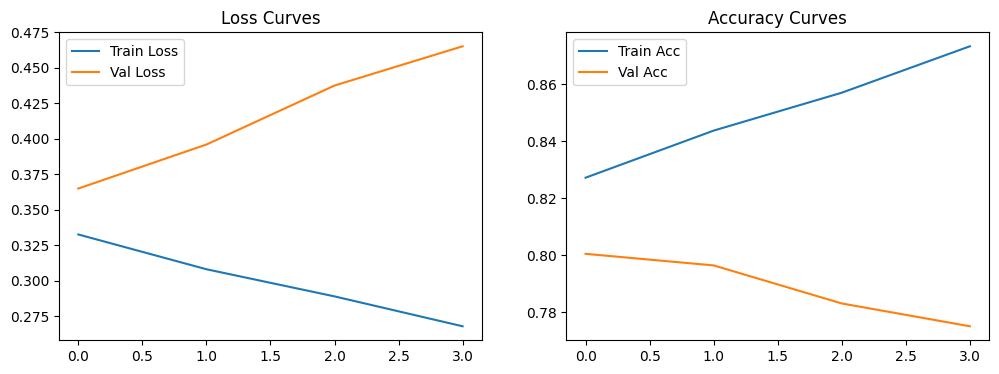

In [22]:
# -----------------------------
# 6. Evaluate + visualize
# -----------------------------
y_pred = (model.predict([X1_val,X2_val])>0.5).astype(int).flatten()
print(classification_report(y_val, y_pred))

fig, axs = plt.subplots(1,2, figsize=(12,4))
axs[0].plot(history.history['loss'], label='Train Loss')
axs[0].plot(history.history['val_loss'], label='Val Loss')
axs[0].set_title('Loss Curves'); axs[0].legend()

axs[1].plot(history.history['accuracy'], label='Train Acc')
axs[1].plot(history.history['val_accuracy'], label='Val Acc')
axs[1].set_title('Accuracy Curves'); axs[1].legend()
plt.show()

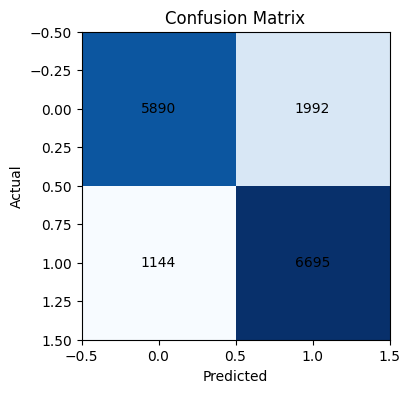

In [23]:
# -----------------------------
# 7. Confusion matrix
# -----------------------------
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(4,4))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('Actual')
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.show()

In [24]:
# ================================================================
# Step 8 – Full Evaluation (Accuracy, Precision, Recall, F1, ROC-AUC)
#           + ASCII "graphs" + Save Report
# ================================================================
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import numpy as np
import joblib
from pathlib import Path

# --- Compute predictions & probabilities ---
y_prob = model.predict([X1_val, X2_val]).flatten()
y_pred = (y_prob > 0.5).astype(int)

# --- Metrics ---
acc  = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred)
rec  = recall_score(y_val, y_pred)
f1   = f1_score(y_val, y_pred)
roc  = roc_auc_score(y_val, y_prob)

# --- Display numerically ---
print(f"{'='*60}")
print("  Evaluation Metrics for BiLSTM Siamese Model")
print(f"{'='*60}")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-Score : {f1:.4f}")
print(f"ROC-AUC  : {roc:.4f}")
print(f"{'='*60}\n")

# --- ASCII Bar “graphs” (textual visualization) ---
def bar(metric, value):
    bar_len = int(value * 50)
    return f"{metric:<10}: {'█'*bar_len}{'-'*(50-bar_len)} | {value:.3f}"

print("ASCII Performance Bars:\n")
print(bar("Accuracy", acc))
print(bar("Precision", prec))
print(bar("Recall", rec))
print(bar("F1-Score", f1))
print(bar("ROC-AUC", roc))
print("\n")

# --- ROC Curve points (textual trend preview) ---
fpr, tpr, thr = roc_curve(y_val, y_prob)
print("ROC Curve sample points (FPR  TPR  Threshold)")
for i in range(0, len(fpr), max(1, len(fpr)//10)):
    print(f"{fpr[i]:.3f}   {tpr[i]:.3f}   {thr[i]:.3f}")

# --- Save evaluation report ---
report_lines = [
    "BiLSTM Siamese Evaluation Report",
    "="*40,
    f"Accuracy : {acc:.4f}",
    f"Precision: {prec:.4f}",
    f"Recall   : {rec:.4f}",
    f"F1-Score : {f1:.4f}",
    f"ROC-AUC  : {roc:.4f}",
    "",
    "ROC Curve sample points (FPR, TPR, Threshold):",
]
report_lines += [f"{fpr[i]:.4f},{tpr[i]:.4f},{thr[i]:.4f}" for i in range(0, len(fpr), max(1, len(fpr)//10))]

report_text = "\n".join(report_lines)
report_path = Path(r"F:\semester 9\Legal_clause_NLP\bilstm_evaluation_report.txt")
with open(report_path, "w", encoding="utf-8") as f:
    f.write(report_text)
print(f"\n Evaluation report saved to:\n{report_path}")

# --- Save model & tokenizer (for re-import later) ---
model.save(str(Path(r"F:\semester 9\Legal_clause_NLP\bilstm_siamese_model.h5")))
joblib.dump(tokenizer, Path(r"F:\semester 9\Legal_clause_NLP\tokenizer_bilstm.pkl"))
print(" Model and tokenizer exported successfully.")


492/492 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step
  Evaluation Metrics for BiLSTM Siamese Model
Accuracy : 0.8005
Precision: 0.7707
Recall   : 0.8541
F1-Score : 0.8102
ROC-AUC  : 0.9080

ASCII Performance Bars:

Accuracy  : ████████████████████████████████████████---------- | 0.801
Precision : ██████████████████████████████████████------------ | 0.771
Recall    : ██████████████████████████████████████████-------- | 0.854
F1-Score  : ████████████████████████████████████████---------- | 0.810
ROC-AUC   : █████████████████████████████████████████████----- | 0.908




ROC Curve sample points (FPR  TPR  Threshold)
0.000   0.000   inf
0.000   0.376   1.000
0.015   0.548   0.891
0.060   0.618   0.703
0.109   0.691   0.642
0.160   0.761   0.593
0.215   0.821   0.540
0.281   0.876   0.467
0.351   0.922   0.389
0.437   0.965   0.285

 Evaluation report saved to:
F:\semester 9\Legal_clause_NLP\bilstm_evaluation_report.txt
 Model and tokenizer exported successfully.
